In [1]:
import sys
sys.path.append("../")

In [2]:
import config

import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import os
import torch

from data.eft_dataset import EFTDataset
from data.display_utils import display_model
from models.smpl import get_smpl_model
from data.utils import rot6d_to_rotmat,orth_proj


In [35]:
from models.hmr import HMR
from models.prohmr import ProHMR
cfg = {'model':{'custom_backbone':True,
       'norelu':True,
       'use_extra_smpl':True}
}

model_hmr = HMR(cfg=cfg)
model_prohmr = ProHMR(cfg=cfg)

MODEL REGRESSOR ARCHITECTURE
Sequential(
  (0): Linear(in_features=2205, out_features=1024, bias=True)
  (1): Identity()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): Identity()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=157, bias=True)
)
LOG:: Using custom BackBone
LOG:: Using custom BackBone


In [36]:
chkpt_hmr = torch.load('/gpu-data2/skar/experiments/hmr_custom_backbone_norelu_withshapeloss_withreprojectionlossv3/best.pt',map_location='cpu')
chkpt_prohmr = torch.load('/gpu-data2/skar/experiments/prohmr_custom_backbone_withshapeloss_withreprojectionloss_extrasmpl_withexplosses/best.pt',map_location='cpu')
#print(chkpt.keys())

model_hmr.load_state_dict(chkpt_hmr['model_state_dict'])
model_prohmr.load_state_dict(chkpt_prohmr['model_state_dict'])
model_hmr.eval()
model_prohmr.eval()

ProHMR(
  (encoder): CustomResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [5]:
dataset = EFTDataset(datasets=['coco14_val'],is_train=False)

In [6]:
smpl = get_smpl_model(use_feet_keypoints=True,use_hands=True,extra=True)

In [185]:
sample = dataset[11]

In [186]:
#cam,pose,shape = model_hmr(sample['img'].unsqueeze(0))
#pose_mat = rot6d_to_rotmat(pose[-1].reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
#output_hmr = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape[-1],pose2rot=False)
pose,shape,_ = model_prohmr.sample(sample['img'].unsqueeze(0))
pose_mat = rot6d_to_rotmat(pose.reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
output_prohmr1 = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape,pose2rot=False)

pose,shape,_ = model_prohmr.sample(sample['img'].unsqueeze(0))
pose_mat = rot6d_to_rotmat(pose.reshape(-1,6)).reshape(-1,24,3,3).flatten(2,3)
output_prohmr2 = smpl(global_orient=pose_mat[:,:1,:],body_pose=pose_mat[:,1:,:],betas=shape,pose2rot=False)

pose_gt = sample['pose'].unsqueeze(0).flatten(2,3)
shape_gt = sample['shape'].unsqueeze(0)
output_gt = smpl(global_orient=pose_gt[:,:1,:],body_pose=pose_gt[:,1:,:],betas=shape_gt,pose2rot=False)

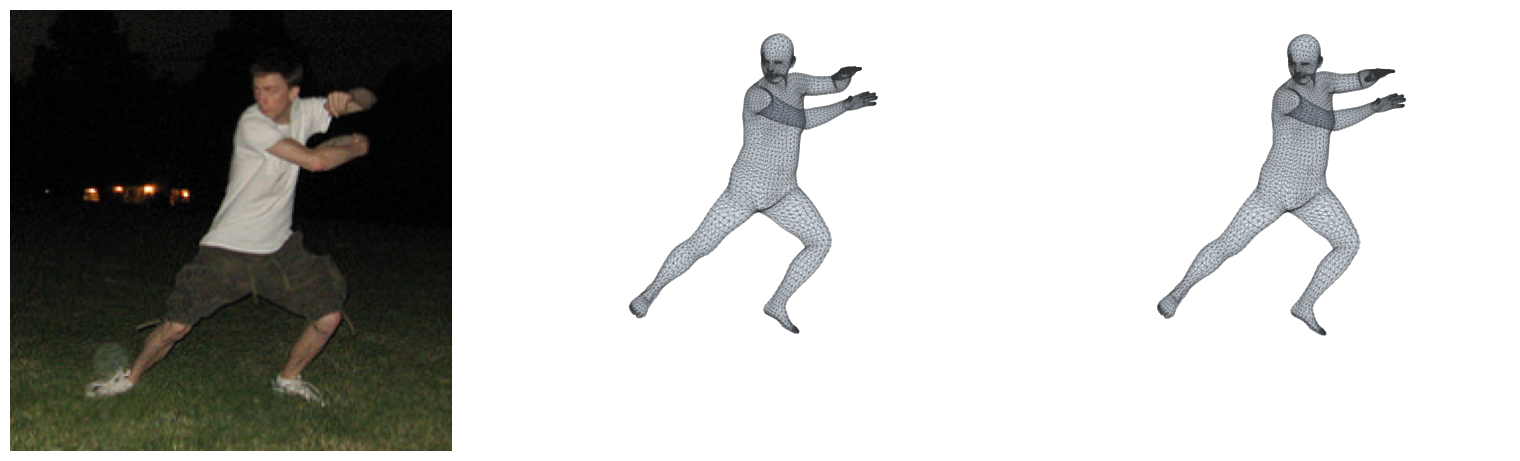

In [187]:
fig= plt.figure(figsize=(15,5))
ax1 = fig.add_axes(131)
ax2 = fig.add_axes(132,projection='3d')
ax3 = fig.add_axes(133,projection='3d')

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
ax1.imshow(img.permute(1,2,0).numpy())
ax1.set_axis_off()

ax2 = display_model(
            {'verts': output_prohmr1.vertices.cpu().detach(),
             'joints': output_prohmr1.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False,
            ax=ax2,
            alpha=0.1)
ax2.view_init(elev=-90,azim=-90)
ax2.set_axis_off()

ax3 = display_model(
            {'verts': output_prohmr2.vertices.cpu().detach(),
             'joints': output_prohmr2.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False,
            ax=ax3)
ax3.view_init(elev=-90,azim=-90)
ax3.set_axis_off()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37
38
39
40


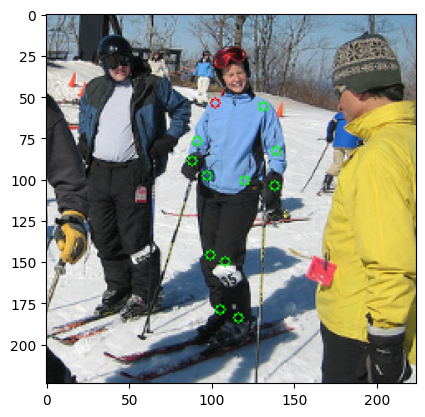

In [141]:
kp2s = sample['keypoints2d'].to(int).numpy()
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
new_img = img.permute(1,2,0).numpy()
for i in range(25,41):
    if sample['visibility2d'][i] > 0:
        color = (0,225,0)
        if i == 33:
            color = (255,0,0)
        new_img = cv2.circle(new_img,center=(kp2s[i][0],kp2s[i][1]),radius=3,color=color)
    else:
        print(i)
plt.imshow(new_img)

In [186]:
pred_kp = orth_proj(output.joints,cam[-1]).squeeze(0)

In [187]:
pred_kp = (pred_kp.detach().numpy() + 1)*112

In [188]:
pred_kp = pred_kp.astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


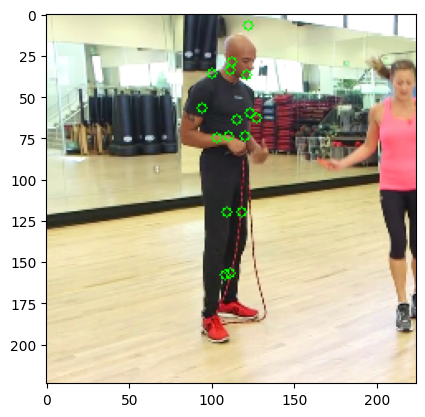

In [196]:
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
new_img = img.permute(1,2,0).numpy()
for i in range(25,41):
    new_img = cv2.circle(new_img,center=(pred_kp[i][0],pred_kp[i][1]),radius=3,color=(0,255,0))
plt.imshow(new_img)

In [ ]:
kp